In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


# Imports

In [2]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models


# To Ensure reproducibility 
np.random.seed(42)
tf.random.set_seed(42)


2025-08-24 18:19:24.048444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756059564.210990      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756059564.261752      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Number of GPU = 1


In [4]:

# List everything inside the dataset directory
dataset_path = "/kaggle/input/mnist-dataset"
print(os.listdir(dataset_path))


['t10k-labels-idx1-ubyte', 'train-images.idx3-ubyte', 't10k-images-idx3-ubyte', 't10k-labels.idx1-ubyte', 't10k-images.idx3-ubyte', 'train-labels.idx1-ubyte', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte']


# Loading Dataset

In [5]:
# Loading dataset directly from Keras
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test :", x_test.shape)
print("y_test :", y_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train: (60000, 28, 28)
y_train: (60000,)
x_test : (10000, 28, 28)
y_test : (10000,)


# Showing first 80 images

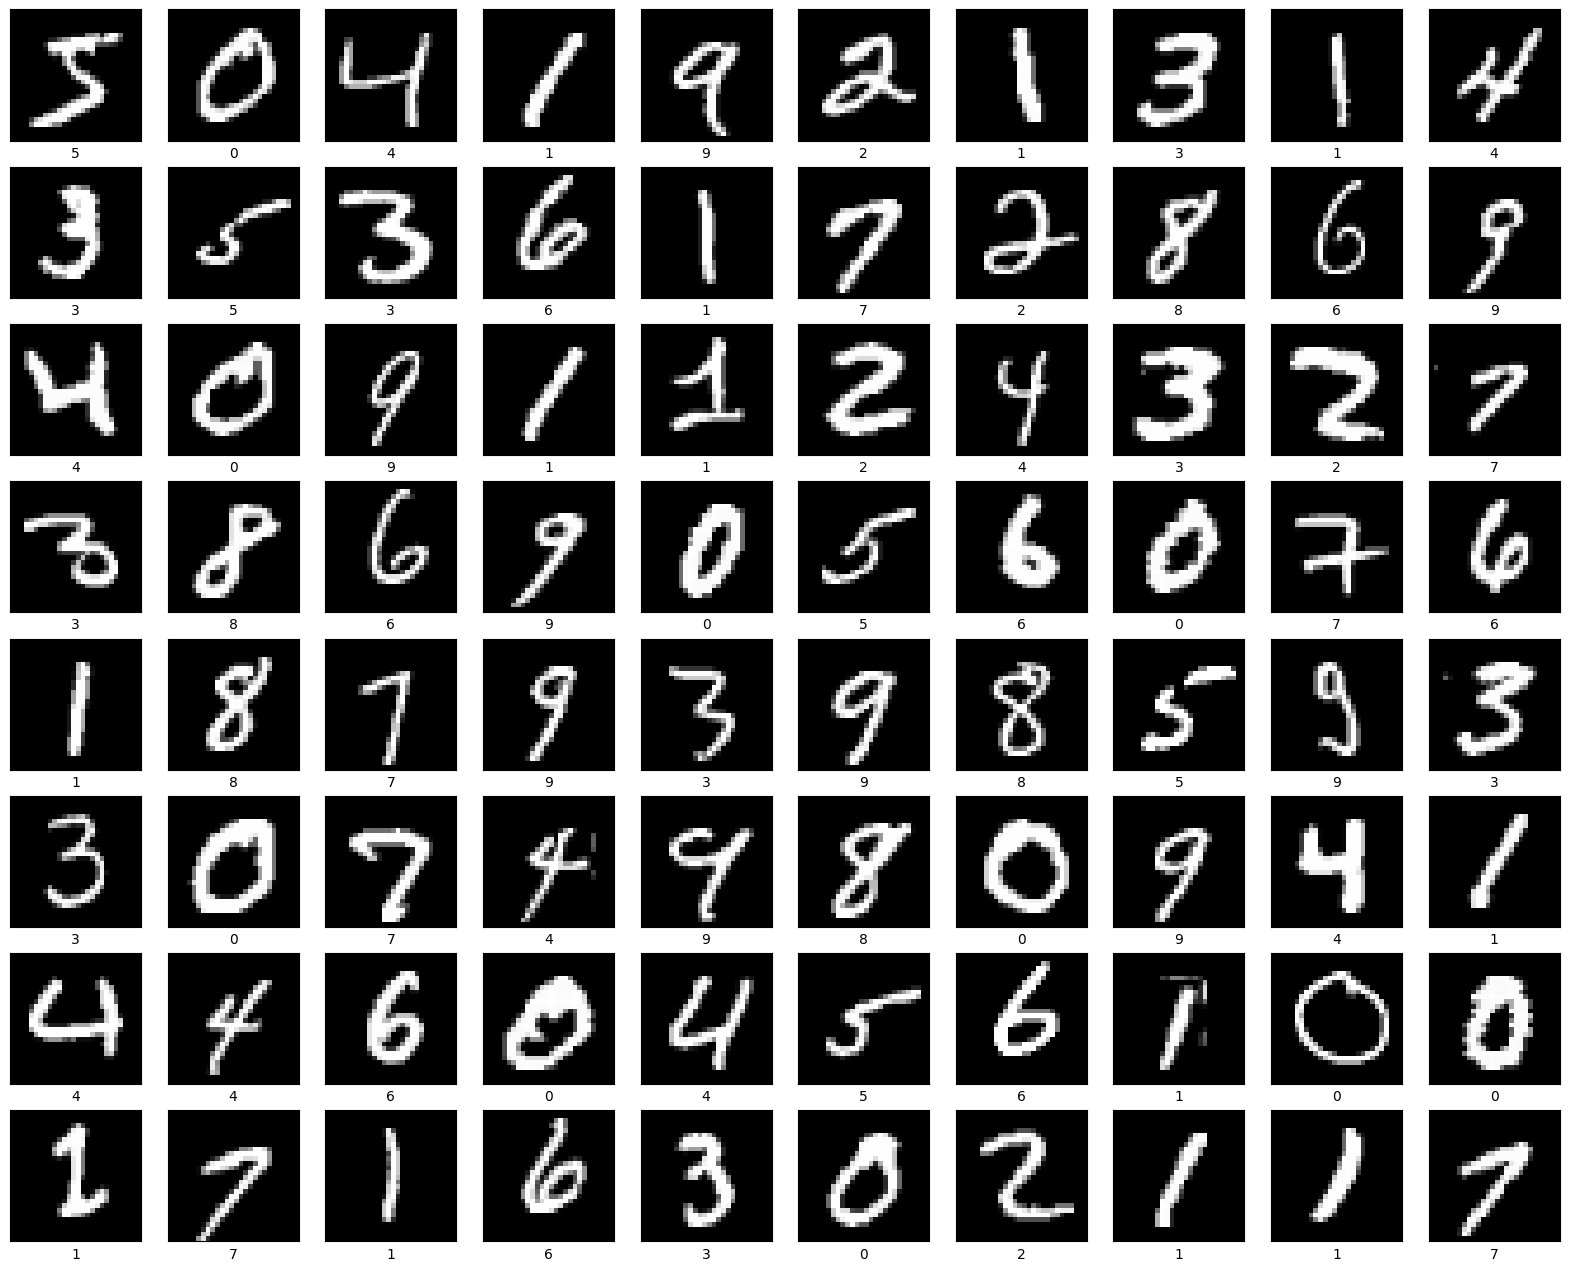

In [6]:
plt.figure(figsize=(20, 16))
for i in range(80):
    plt.subplot(8, 10, i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(str(y_train[i]))
plt.show()

In [7]:
# Normalize to [0,1] # → scaling pixel values to [0,1] for better training.
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0


#(CNNs) usually expect input as:(batch_size, height, width, channels).
#That’s why i added an extra dimension:

x_train = np.expand_dims(x_train, -1)  
x_test  = np.expand_dims(x_test,  -1)  


print(x_train.shape)  
print(x_test.shape) 


(60000, 28, 28, 1)
(10000, 28, 28, 1)


#  Building CNN

* Applies 32 filters of size 3×3 on the input image ,ReLU adds non-linearity (removes negatives)
* Reduces the image size by half (downsampling).
* Applies 64 filters of size 3×3,Detects more complex patterns
* Again reduces size by half.
* Uses 128 filters,Learns very detailed patterns (like digit shapes).
* Converts the 2D feature maps into a 1D vector.
* Randomly turns off 50% of neurons during training.
* Output layer with 10 neurons, Softmax gives probability distribution



In [8]:
def build_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    return model

model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1756059579.522229      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

# Compile

In [9]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#how to learn and what to measure

In [10]:
h = model.fit(x=x_train, y=y_train, epochs=20, batch_size=64, validation_split=0.3)  
#updates weights after every 64 images
#30% of training data is kept aside to check performance on unseen data

Epoch 1/20


I0000 00:00:1756059583.224126      62 service.cc:148] XLA service 0x7a3794004de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756059583.224589      62 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756059583.502059      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


 53/657 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3524 - loss: 1.8655

I0000 00:00:1756059585.706918      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


657/657 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.7989 - loss: 0.6191 - val_accuracy: 0.9787 - val_loss: 0.0730
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9730 - loss: 0.0895 - val_accuracy: 0.9816 - val_loss: 0.0576
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9826 - loss: 0.0580 - val_accuracy: 0.9834 - val_loss: 0.0557
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9869 - loss: 0.0458 - val_accuracy: 0.9857 - val_loss: 0.0512
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9887 - loss: 0.0373 - val_accuracy: 0.9861 - val_loss: 0.0512
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9910 - loss: 0.0304 - val_accuracy: 0.9870 - val_loss: 0.0472
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9922 - loss: 0.0261 - val_accuracy: 0.9878 - val_loss: 0.0550
Epoch 8/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9927 - loss: 0.0231 - val_accuracy: 0.9888 - val

# Evaluate

In [11]:
#on test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9876 - loss: 0.0794
Test Accuracy: 0.9900 | Test Loss: 0.0675


# Plotting

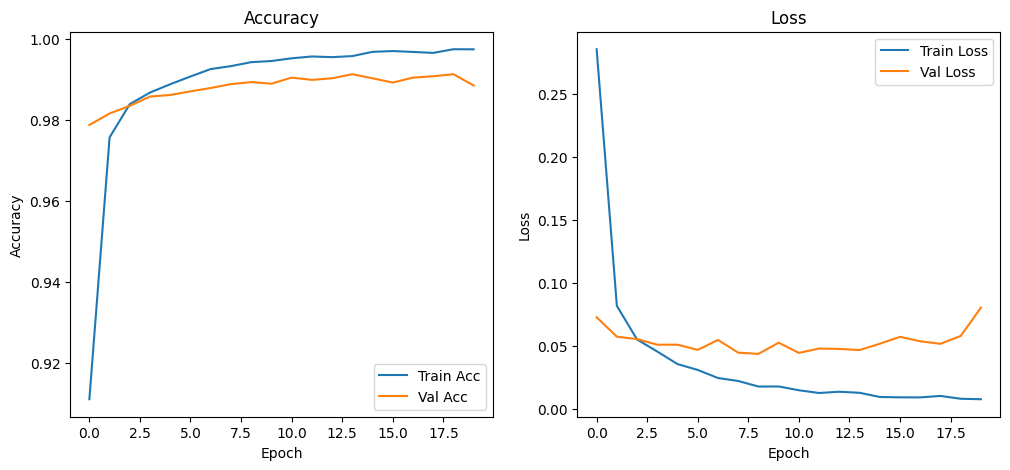

In [12]:
plt.figure(figsize=(12,5))

# Accuracy subplot
plt.subplot(1, 2, 1)  
plt.plot(h.history['accuracy'], label='Train Acc')
plt.plot(h.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)  
plt.plot(h.history['loss'], label='Train Loss')
plt.plot(h.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluate the model on the test dataset

In [13]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9876 - loss: 0.0794

Test accuracy: 0.9900000095367432


# Make predictions on the entire test images

In [14]:
predictions = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


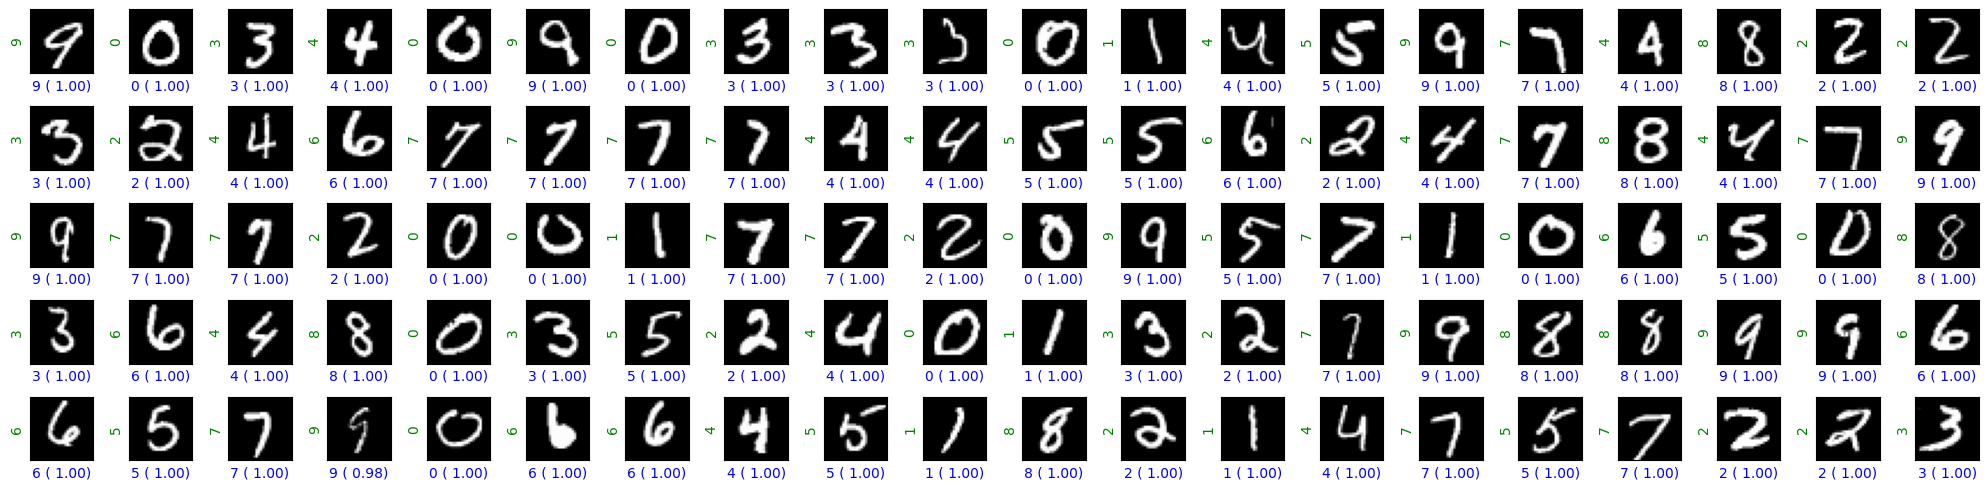

In [15]:
ROWS = 5
COLS = 20

random_indices = random.sample(range(x_test.shape[0]), ROWS*COLS)
sample_images = x_test[random_indices, :]
sample_labels = y_test[random_indices]
predictions = model.predict(sample_images)

i = 0

plt.figure(figsize=(20,5))
for r in range(ROWS):
    for c in range(COLS):
        plt.subplot(ROWS, COLS, i+1)
        plt.imshow(sample_images[i].reshape(28,28), cmap=plt.cm.gray)
        plt.xticks([])
        plt.yticks([])
        prediction = np.argmax(predictions[i]) 
        confidence = predictions[i][prediction]
        if sample_labels[i] == prediction:
            plt.xlabel(f"{prediction} ({confidence: .2f})", color='b')
        else:
            plt.xlabel(f"{prediction} ({confidence: .2f})", color='r')
        plt.ylabel(sample_labels[i], color='g')
        i += 1
        
plt.tight_layout()
plt.show()

# Predicting a single image

In [16]:
def test(i):
    # Get the i-th test image
    img = x_test[i]  # shape: (28, 28, 1)

    # Add batch dimension: (1, 28, 28, 1)
    img_batch = np.expand_dims(img, axis=0)

    # Make prediction
    predictions = model.predict(img_batch)
    prediction = np.argmax(predictions)
    confidence = predictions[0][prediction]

    # Plot the image
    plt.figure()
    plt.imshow(img.squeeze(), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])

    # Ground truth
    plt.ylabel(f"True Label: {y_test[i]}", color='g')

    # Prediction with confidence
    if y_test[i] == prediction:
        plt.xlabel(f"Prediction = {prediction} (Confidence = {confidence:.2f})", color='b')
    else:
        plt.xlabel(f"Prediction = {prediction} (Confidence = {confidence:.2f})", color='r')

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step


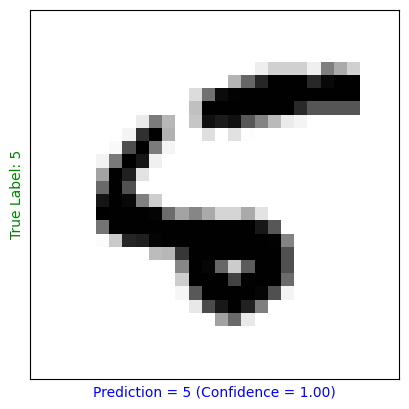

In [17]:
test(8)

# Saving The Trained Model

In [18]:
model.save('/kaggle/working/digit_cnn.h5')
print("Saved model to digit_cnn.h5")

Saved model to digit_cnn.h5
